# Deep Learning Final Project: Dementia Classifier



**Helit Bauberg, #027466002**

**Or Simhi #201122892**


### Environment Setup - the standard stuff


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/DL Final'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Alzheimer_s Dataset', '__pycache__', 'ConvNet-exe2.ipynb', 'An MRI-based deep learning approach for accurate.pdf', 'sensors-20-03243-v2.pdf', 'dementia_classifier.ipynb', 'dementia_classifier_new.ipynb', 'dementia_classifier_old.py', 'dementia_classifier.py', 'dementia_classifier_v1.ipynb']


In [141]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "EAT"
time.tzset()

from dementia_classifier import hello_nondemented_people
hello_nondemented_people()


dementia_classifier_path = os.path.join(GOOGLE_DRIVE_PATH, 'dementia_classifier.py')
dementia_classifier_edit_time = time.ctime(os.path.getmtime(dementia_classifier_path))
print('dementia_classifier.py last edited on %s' % dementia_classifier_edit_time)

dementia_classifier_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, 'Alzheimer_s Dataset/')


Hello from Classifer! Remember me?
dementia_classifier.py last edited on Sun Jul  9 10:09:21 2023


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

torch.manual_seed(0)
torch.cuda.manual_seed(0)

plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['font.size'] = 14

We will use the GPU to accelerate our computation.

In [7]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


A set of applicable data trasnformations for preprocessing and sample generation pipelines

In [8]:
import torchvision.transforms.functional as TF

def sharpness_transform(img):
    return TF.adjust_sharpness(img, sharpness_factor=2)

def contrast_transform(img):
    return TF.adjust_contrast(img, contrast_factor=1.5)

def gamma_transform(img):
  return TF.adjust_gamma(img, gamma = 1.5) #[, gain])

def gaussian_transform(img):
  return TF.gaussian_blur(img, kernel_size=(3, 3), sigma=(0.1, 0.1))

def invert_transform(img):
  return TF.invert(img)

#affine(img, angle, translate, scale, shear)



# Test bed for image manipulations

JPEG (176, 208)xL


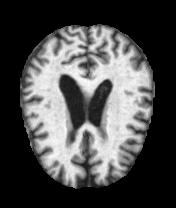

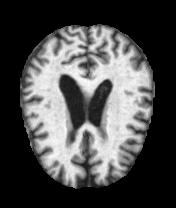

mean, std before toTensor:  75.53316215034965 90.62959503378887
mean, std after toTensor:  tensor(0.2962) tensor(0.3554)
toTensor image shape torch.Size([1, 208, 176])
after transform image shape torch.Size([1, 208, 176])


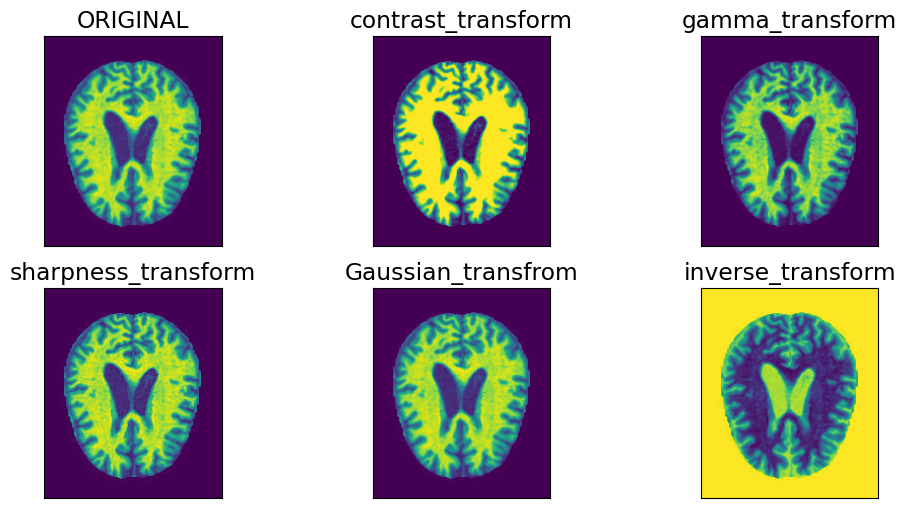

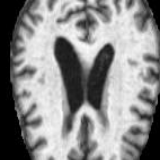

In [ ]:
import numpy as np
from PIL import Image
import torchvision.transforms as T

path = dementia_classifier_dataset_path + 'train/ModerateDemented/moderateDem51.jpg'
im = Image.open(path)
print( im.format, f"{im.size}x{im.mode}")
im.show()

imh = im.histogram()
#print(imh)

#im = im.convert("RGB")
im.show()

im_tensor = T.ToTensor()(im)

imh = im_tensor.histogram()
mean = np.mean(im)
std = np.std(im)

print ('mean, std before toTensor: ', mean, std)
npimg = np.asarray(im)
mean = im_tensor.mean()
std = im_tensor.std()

print ('mean, std after toTensor: ', mean, std)
print('toTensor image shape',(im_tensor.shape))


fig, axes = plt.subplots(2, 3, figsize=(12, 6))

im_tensor_orig = im_tensor
im_tensor = contrast_transform(im_tensor_orig)
print('after transform image shape',(im_tensor.shape))

im_PIL_orig = T.ToPILImage(im)
#print(im.size)

im_tensor = (im_tensor_orig)
im_np = np.transpose(im_tensor, (1, 2, 0))
axes[0][0].imshow(np.transpose(im_np, (0, 1, 2)))
axes[0][0].set_title('ORIGINAL')
axes[0][0].set_xticks([])  # Remove x-axis ticks
axes[0][0].set_yticks([])  # Remove y-axis ticks


im_tensor = contrast_transform(im_tensor_orig)
im_np = np.transpose(im_tensor, (1, 2, 0))
axes[0][1].imshow(np.transpose(im_np, (0, 1, 2)))
axes[0][1].set_title('contrast_transform')
axes[0][1].set_xticks([])  # Remove x-axis ticks
axes[0][1].set_yticks([])  # Remove y-axis ticks1

im_tensor = gamma_transform(im_tensor_orig)
im_np = np.transpose(im_tensor, (1, 2, 0))
axes[0][2].imshow(np.transpose(im_np, (0, 1, 2)))
axes[0][2].set_title('gamma_transform')
axes[0][2].set_xticks([])  # Remove x-axis ticks
axes[0][2].set_yticks([])  # Remove y-axis ticks

im_tensor = sharpness_transform(im_tensor_orig)
im_np = np.transpose(im_tensor, (1, 2, 0))
axes[1][0].imshow(np.transpose(im_np, (0, 1, 2)))
axes[1][0].set_title('sharpness_transform')
axes[1][0].set_xticks([])  # Remove x-axis ticks
axes[1][0].set_yticks([])  # Remove y-axis ticks

im_tensor = gaussian_transform(im_tensor_orig)
im_np = np.transpose(im_tensor, (1, 2, 0))
axes[1][1].imshow(np.transpose(im_np, (0, 1, 2)))
axes[1][1].set_title('Gaussian_transfrom')
axes[1][1].set_xticks([])  # Remove x-axis ticks
axes[1][1].set_yticks([])  # Remove y-axis ticks

im_tensor = invert_transform(im_tensor_orig)
im_np = np.transpose(im_tensor, (1, 2, 0))
axes[1][2].imshow(np.transpose(im_np, (0, 1, 2)))
axes[1][2].set_title('inverse_transform')
axes[1][2].set_xticks([])  # Remove x-axis ticks
axes[1][2].set_yticks([])  # Remove y-axis ticks

plt.show()

#(top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(150, 150))(im_tensor_orig)
#plot([top_left, top_right, bottom_left, bottom_right, center])

resize_cropper = T.RandomResizedCrop(size=(160, 160))(im_tensor_orig)
#resized_crops = [resize_cropper(im_tensor_orig) for _ in range(4)]

im_tensor = T.RandomVerticalFlip()

resize_cropper = T.ToPILImage()(resize_cropper)
resize_cropper.show()
#im_np = np.transpose(top_left, (1, 2, 0))
#im_np.show()


# generate_sample(img)
# we use this to create more samples for undersampled classes
def get_res_crop(img):
  transform = T.RandomResizedCrop(size=(176, 176),
                                  scale=(0.08, 1.0),
                                  ratio=(0.75, 1.25))
  image_crop = transform(img)
  return image_crop


def get_patches(imgs):
    # orig_img.shape = (NN, 3, 208, 176)

    img_t = T.Compose([T.ToPILImage(),
                       T.CenterCrop(100),
                       T.FiveCrop(44)])
    patch_t = T.Compose([T.Resize(208,176),
                         T.ToTensor(),
                         ])

    resized_imgs = []

    for img in imgs:
        five_crop = img_t(img)
        #f_crops = torch.stack(list(map(patch_t, five_crop)))
        f_crops = torch.stack(list(five_crop))
        resized_imgs.append(f_crops)
    return torch.stack(resized_imgs)


# Load and examine the Train dataset

##Transformations pipeplines:

In [9]:
import torchvision.transforms as T


# This is used to generate more samples for the undersampled classes.
# Crop only. Once we have the full aumgented dataset, we apply various random
# transformations on the entire training+validation dataset
random_crop = T.RandomCrop(size=(176))
#random_crop = T.RandomResizedCrop(size=(176), scale=(0.08, 1.0), ratio=(0.75, 1.25))

# Initial preprocessing - applied on both training and test data
p_preproc = T.Compose([
    T.CenterCrop(176),
    T.ToTensor(),             # This normalizes all data to (0,1)
    ])


# We apply randomly picked transformation (or none) on the entire train set
p_manip_samples = [
    T.Lambda(lambda img: img),
    T.RandomHorizontalFlip(p=1),
    T.RandomResizedCrop(size=(176),antialias=None),
    T.RandomCrop(size=(176)),
    #sharpness_transform,
    #contrast_transform,
    #gamma_transform,
    #gaussian_transform,
    #invert_transform,
    ]

# Randomly pick the transformation
random_manip = T.RandomChoice(p_manip_samples)

# Combine the preprocessing transformation and the random tranform
combined_transforms = T.Compose([p_preproc, random_manip])



##Load and examine the Initial Train dataset:

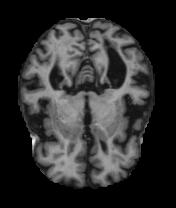

JPEG (176, 208)xL
train set data class distribution:
Class MildDemented: 2151 samples (24%)
Class ModerateDemented: 2132 samples (24%)
Class NonDemented: 2560 samples (29%)
Class VeryMildDemented: 1792 samples (20%)
8635 samples in total


In [10]:
from torchvision import datasets
from collections import Counter
from PIL import Image

# Get the data and labels - Testing
path = dementia_classifier_dataset_path + 'train'

# Create tje initial Train dataset
orig_dataset_train = datasets.ImageFolder(path) #, transform=p_preproc)

img, _ = orig_dataset_train.samples[0]
im = Image.open(img)
im.show()

print( im.format, f"{im.size}x{im.mode}")

# Get the labels of all samples
labels = orig_dataset_train.targets

# Count the number of samples per class
class_counts = Counter(labels)

# Get the mapping from class IDs to class names
id_to_class = {v: k for k, v in orig_dataset_train.class_to_idx.items()}

# Print the number of samples per class
total_count = 0
for class_id, count in class_counts.items():
  total_count += count

print("train set data class distribution:")
for class_id, count in class_counts.items():
    print(f"Class {id_to_class[class_id]}: {count} samples ({100 * count // total_count }%)")

print(f"{total_count} samples in total")


# Data Augmentation:
Train dataset is very imbalanced - 'ModerateDemented' samples are only about 1% of the samples, 'MildDemented' less than 15%. We will use the existing samples to create more images for this class by using transformations that won't change the important sMRI scan features of shape, resolution, or spacial transformation.
Test Samples - Class MildDemented: 14% (717/5121) ==> duplicate amount of MildDemented
Test Samples - Class ModerateDemented:  1% (52/5121) ==> create ~1500 samples


# Generate samples for class MildDemented:
Perform two random crops transformation per image.
 (we go from 717 -> 2151)


5121


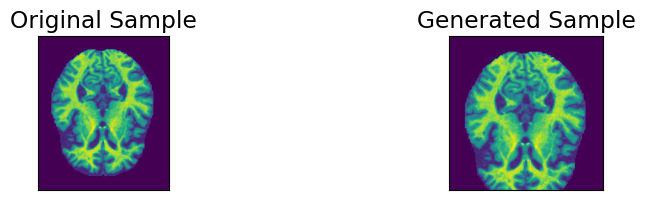

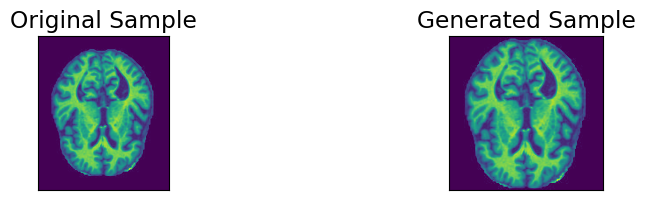

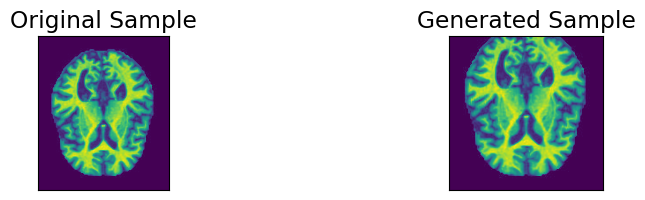

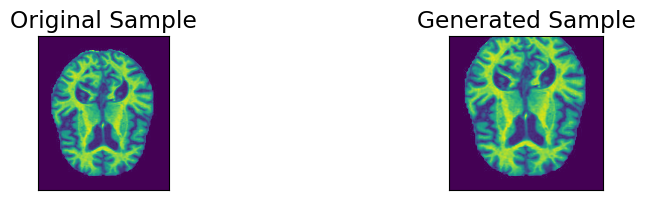

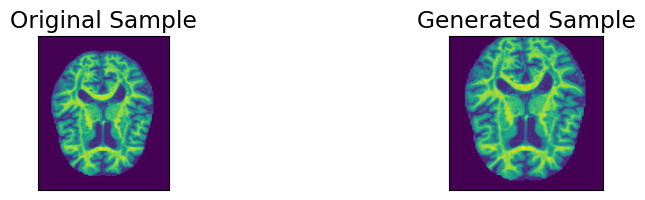

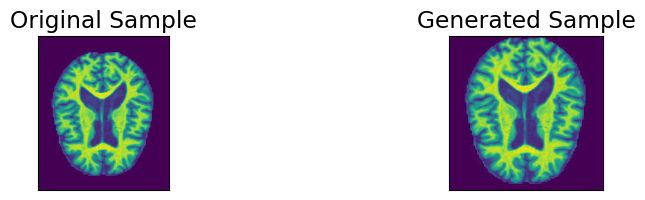

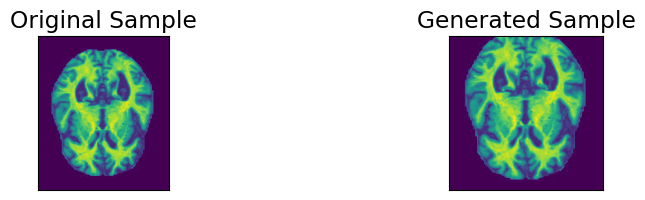

Class VeryMildDemented: New count: 2151


In [ ]:
from dementia_classifier import AugmentClass

class_name_to_augment = 'MildDemented'
class_id_to_augment = orig_dataset_train.class_to_idx[class_name_to_augment]

# 2 new samples to generate for each original sample
num_augmented_samples = 2

# This dataset contains only class 'MildDemented' samples - original and augemnted
dataset_train_MildD_augmented_count = AugmentClass(
    original_dataset=orig_dataset_train,
    class_to_augment=class_id_to_augment,
    augmentation_transform=random_crop,
    num_augmented_samples=num_augmented_samples
)

print(f"Class {id_to_class[class_id]}: New count: {dataset_train_MildD_augmented_count}")




# Generate samples for ModerateDemented:
Since we only have 52 samples, we loop on all and randomly generate 40 image transformation per sample to get to over 20% data samples for class MildDemented

In [ ]:
from dementia_classifier import AugmentClass

class_name_to_augment = 'ModerateDemented'
class_id_to_augment = orig_dataset_train.class_to_idx[class_name_to_augment]

# We only have 52 samples, we need to generate 40 augmented samples for each original sample
num_augmented_samples = 40

# This dataset contains only class 'ModerateDemented' samples - original and augemnted
dataset_train_ModerateD_augmented_count = AugmentClass(
    original_dataset=orig_dataset_train,
    class_to_augment=class_id_to_augment,
    augmentation_transform=random_crop,
    num_augmented_samples=num_augmented_samples
)

print(f"Class {id_to_class[class_id]}: New count: {dataset_train_ModerateD_augmented_count}")


5121
Class VeryMildDemented: New count: 2132


# normalization checks:
 calaculate trainset mean and std, for pre-processing Normalization step - trying to figure out if we need any normalization in the preproc after ToTensor()

In [ ]:
from torch.utils.data import DataLoader

# Get the data and labels - Testing
path = dementia_classifier_dataset_path + 'train'

# Create the full train/val dataset now that we have balanced samples.
# only pipelines- preproc pipeline and randomtransfrom are sent to the loader
stats_ds = datasets.ImageFolder(path, transform=p_preproc)
ds_loader = DataLoader(stats_ds, batch_size=20, shuffle=False)

imgs = torch.stack([img_t for img_t, _ in ds_loader], dim=1)
imgs.shape
mean = imgs.view(1, -1).mean(dim=1)
std = imgs.view(1, -1).std(dim=1)

'''
mean = 0.0
for images, _ in ds_loader:
    batch_samples = images.size(0)  # batch size (the first dimension)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(ds_loader.dataset)

std = 0.0
for images, _ in ds_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    std += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(std / (len(ds_loader.dataset)*176*176))
'''

print(f"Trainset mean: {mean} std: {std}")


KeyboardInterrupt: ignored

# Check new sample / class distribution - new and original samples are all now on drive, sorted:

In [11]:
BATCH_SIZE = 8

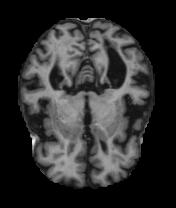

JPEG (176, 208)xL
train set data class distribution:
Class MildDemented: 2151 samples (24%)
Class ModerateDemented: 2132 samples (24%)
Class NonDemented: 2560 samples (29%)
Class VeryMildDemented: 1792 samples (20%)
8635 samples in total


In [12]:

# Get the data and labels - Testing
path = dementia_classifier_dataset_path + 'train'

# Create the full train/val dataset now that we have balanced samples.
# both pipelines- preproc pipeline and randomtransfrom are sent to the loader as combined_transforms.
full_dataset_train = datasets.ImageFolder(path, transform=combined_transforms)

img, _ = full_dataset_train.samples[0]
im = Image.open(img)
im.show()

print( im.format, f"{im.size}x{im.mode}")

# Get the labels of all samples
labels = full_dataset_train.targets

# Count the number of samples per class
class_counts = Counter(labels)

# Get the mapping from class IDs to class names
IDX_TO_CLASS = {v: k for k, v in full_dataset_train.class_to_idx.items()}

# Print the number of samples per class
total_count = 0
for class_id, count in class_counts.items():
  total_count += count

print("train set data class distribution:")
for class_id, count in class_counts.items():
    print(f"Class {IDX_TO_CLASS[class_id]}: {count} samples ({100 * count // total_count }%)")

print(f"{total_count} samples in total")


In [13]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

# Load and examine the Test dataset

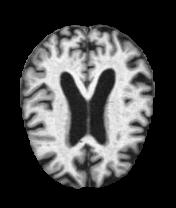

JPEG (176, 208)xL
Loaded TEST dataset:
Class MildDemented: 179 samples (13%)
Class ModerateDemented: 12 samples (0%)
Class NonDemented: 640 samples (50%)
Class VeryMildDemented: 448 samples (35%)
1279 samples in total


In [13]:
from torchvision import datasets
from collections import Counter
from torch.utils.data import DataLoader



# Get the data and labels - Testing
path = dementia_classifier_dataset_path + 'test'

# Run thourgh the same basic preprocessing pipe
dataset_test = datasets.ImageFolder(path, transform=p_preproc)

img, _ = dataset_test.samples[0]
im = Image.open(img)
im.show()

print( im.format, f"{im.size}x{im.mode}")

# Get the labels of all samples
labels = dataset_test.targets

# Count the number of samples per class
class_counts = Counter(labels)

# Get the mapping from class IDs to class names
id_to_class = {v: k for k, v in dataset_test.class_to_idx.items()}

# Print the number of samples per class
total_count = 0
for _, count in class_counts.items():
  total_count += count

print("Loaded TEST dataset:")
for class_id, count in class_counts.items():
    print(f"Class {id_to_class[class_id]}: {count} samples ({100 * count // total_count }%)")
print(f"{total_count} samples in total")

# Create a DataLoader from the dataset
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)



# After creating more samples to balance up the classes sample count, we run the random transformation pipeline on the Train set, to create a variety of features:


p_manip_samples - random transformations to be applied on the full train/valid dataset

Random split Train set to Train/Validate, 20% for validation. We use a function here as this is also called during initial training model assessments, to produce much smaller lodaers.

In [14]:
from dementia_classifier import get_train_val_loader

# create full train/validate dataset loaders
train_loader, valid_loader = get_train_val_loader(ds = full_dataset_train, batch_size = BATCH_SIZE,
                                                  valid_size = 0.2, loader_fraction = 1.0)



Splitting  8635 samples to:  6908 training,  1727 validation



Prepare Test dataset loader:

Retrieve Train set dimensions:

Display first few images from Train dataset:


torch.Size([4, 3, 176, 176])
0.28521138 0.29639322
0.3424672 0.3308288
0.30982277 0.31205258
0.31774253 0.2908178


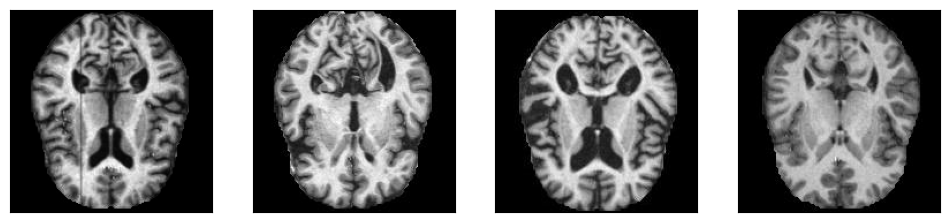

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

dataiter = iter(train_loader)
img, lbl = next(dataiter, 0)
print(img.shape)


fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    img, lbl = next(dataiter, 0)
    im = img[0]
    np_im = im.numpy().transpose((1, 2, 0))

    print(np_im.mean(),np_im.std())
    axes[i].imshow(np_im)
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks

plt.show()



## The model


In [135]:
param_grid = {
    'l_1': [128], # ,64],
    'lr': [0.001], # 0.01, 0.005],               # learning rate
    'weight_decay': [0.0007], #0.0005,0.0003],  # regularization strength
    'optim': ['SGD'], #, 'Adam'],                 # optimizers - 'Adam', 'SGD'
    'momentum': [0.7], #,0.5,0.7],
    'epochs': [100],
    'batch_size': [8],
    'input_size': [(3,176,176)],
    'output_size': [4]
    }

def get_net_params():
  net_params = {}
  for param in param_grid:
    net_params[param] = random.choice(param_grid[param])
    #print (net_params[param])
  return net_params




In [16]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [136]:
torch.cuda.empty_cache()

# Create model instance:

In [137]:
from dementia_classifier import ConvNet, ConvBlockNet, FirstConvNet
net_params = get_net_params()

mynet = ConvNet(input_size=net_params['input_size'],
                num_classes=net_params['output_size'],
                l_1 = net_params['l_1'])

#mynet = ConvBlockNet((3,176,176),3,4,16)

#mynet = FirstConvNet(input_size=net_params['input_size'],
#                     output_size=net_params['output_size'],
#                     l_1 = net_params['l_1'])


mynet = mynet.to(device='cuda')



In [138]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

nodes, _ = get_graph_node_names(mynet)
print('Node names: ', nodes)



Node names:  ['x', 'float', 'conv1', 'relu', 'pool', 'conv2', 'relu_1', 'pool_1', 'conv3', 'relu_2', 'pool_2', 'dropout1', 'conv4', 'relu_3', 'pool_3', 'conv5', 'relu_4', 'pool_4', 'flatten', 'fc1']


# Main - train and test model:

Train and Test model with net_params: {'l_1': 128, 'lr': 0.001, 'weight_decay': 0.0007, 'optim': 'SGD', 'momentum': 0.7, 'epochs': 100, 'batch_size': 8, 'input_size': (3, 176, 176), 'output_size': 4}
Splitting  8635 samples to:  6908 training,  1727 validation
Training - Epoch 1
[1,    50] Training loss: 1.380
[1,   100] Training loss: 1.378
[1,   150] Training loss: 1.364
[1,   200] Training loss: 1.369
[1,   250] Training loss: 1.391
[1,   300] Training loss: 1.384
[1,   350] Training loss: 1.379
[1,   400] Training loss: 1.373
[1,   450] Training loss: 1.385
[1,   500] Training loss: 1.375
[1,   550] Training loss: 1.382
[1,   600] Training loss: 1.378
[1,   650] Training loss: 1.377
[1,   700] Training loss: 1.382
[1,   750] Training loss: 1.384
[1,   800] Training loss: 1.384
[1,   850] Training loss: 1.378
Validation - Epoch 1
[1,    50] Validation loss: 1.383 Accuracy: 27% (110/400)
[1,   100] Validation loss: 1.369 Accuracy: 30% (244/800)
[1,   150] Validation loss: 1.375 Accur

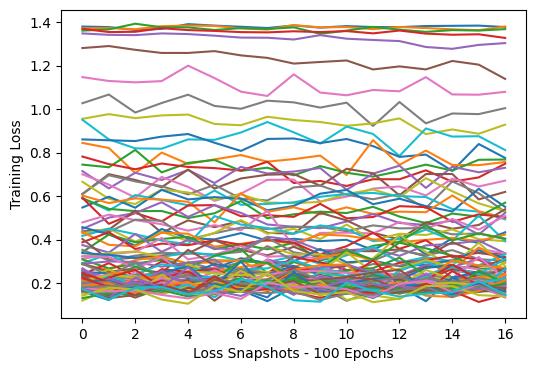

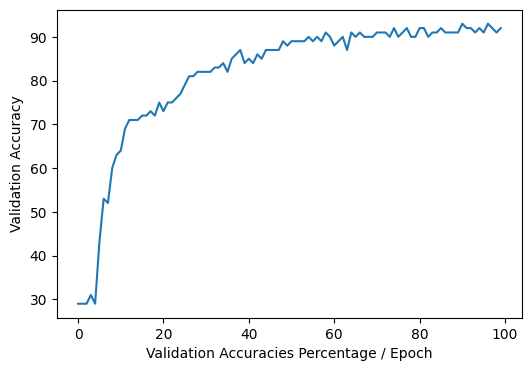

Completed trial # 11 Final Training loss:  0.16258255692540574  Final Validation loss:  0.20850415428598085
Test Accuracy of class MildDemented: 92% (166/179)
Test Accuracy of class ModerateDemented: 75% ( 9/12)
Test Accuracy of class NonDemented: 47% (305/640)
Test Accuracy of class VeryMildDemented: 43% (193/448)
Overall accuracy of the network on the 1279 test images: 52 %


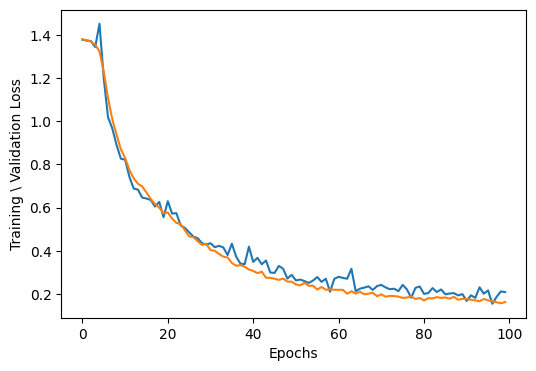

"\n    model_path = 'model_{}_{}'.format('train runs', i)\n    torch.save(model.state_dict(), model_path)\n"

In [139]:
from dementia_classifier import train_model, test_accuracy
import numpy as np

print (f"Train and Test model with net_params: {net_params}")

# Train
model, t_loss, v_loss, f_map = train_model(mynet, full_dataset_train, net_params)

# Test
accuracy,  correct_cls, total_cls = test_accuracy(model, test_loader, classes=4)
#results.append((net_params, t_loss, v_loss, accuracy, correct_cls, total_cls))

# Print Results
print('Completed trial #',i, 'Final Training loss: ',t_loss[net_params['epochs']-1], ' Final Validation loss: ', v_loss[net_params['epochs']-1])
for cls in range(len(IDX_TO_CLASS)):
    print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (IDX_TO_CLASS[cls],
     (100 * correct_cls[cls] // total_cls[cls]), correct_cls[cls], total_cls[cls]))

print(f'Overall accuracy of the network on the {int(np.sum(total_cls))} test images: { accuracy}','%')

plt.plot(v_loss)
plt.plot(t_loss)
plt.xlabel(xlabel='Epochs')
plt.ylabel("Training \ Validation Loss")
plt.show()

'''
    model_path = 'model_{}_{}'.format('train runs', i)
    torch.save(model.state_dict(), model_path)
'''


In [86]:
nodes, _ = get_graph_node_names(mynet)
print(nodes)


['x', 'float', 'conv1', 'relu', 'pool', 'conv2', 'relu_1', 'pool_1', 'conv3', 'relu_2', 'pool_2', 'dropout1', 'conv4', 'relu_3', 'pool_3', 'conv5', 'relu_4', 'pool_4', 'dropout2', 'flatten', 'fc1']


<ipython-input-140-e5548396febc>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  layer = torch.tensor(features[f]).to(device='cpu')


input torch.Size([7, 3, 176, 176])
conv1 torch.Size([7, 128, 176, 176])
pool_conv1 torch.Size([7, 128, 88, 88])
conv2 torch.Size([7, 256, 88, 88])
pool_conv2 torch.Size([7, 256, 44, 44])
conv3 torch.Size([7, 512, 44, 44])
pool_conv3 torch.Size([7, 512, 22, 22])
drop_conv3 torch.Size([7, 512, 22, 22])
conv4 torch.Size([7, 1024, 23, 23])
pool_conv4 torch.Size([7, 1024, 11, 11])
conv5 torch.Size([7, 2048, 12, 12])
pool_conv5 torch.Size([7, 2048, 6, 6])


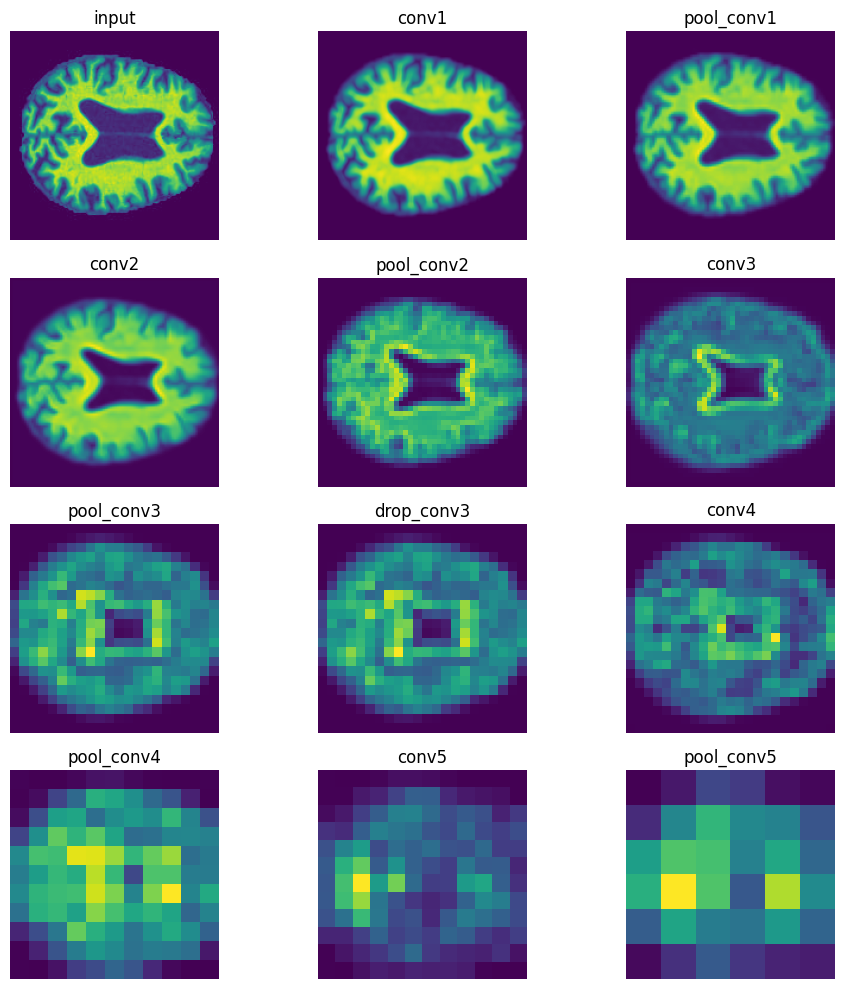

In [140]:

# Extract the features
features = mynet.extract_features()
feature_map = features.keys()
num_feature_maps = len(feature_map)

# Calculate the number of rows and columns for the subplot grid
num_rows = math.ceil(math.sqrt(num_feature_maps))
num_cols = math.ceil(num_feature_maps / num_rows)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, f in enumerate(feature_map):
    layer = torch.tensor(features[f]).to(device='cpu')
    print(f, layer.shape)
    np_layer = layer[0].transpose(0, 2).sum(-1).detach().numpy()

    axs[i // num_cols, i % num_cols].imshow(np_layer)
    axs[i // num_cols, i % num_cols].set_title(f)
    axs[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-132-9cddc19d3809>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv1_filters = torch.tensor(features['pool_conv1'][0]).to(device='cpu')


torch.Size([64, 88, 88])


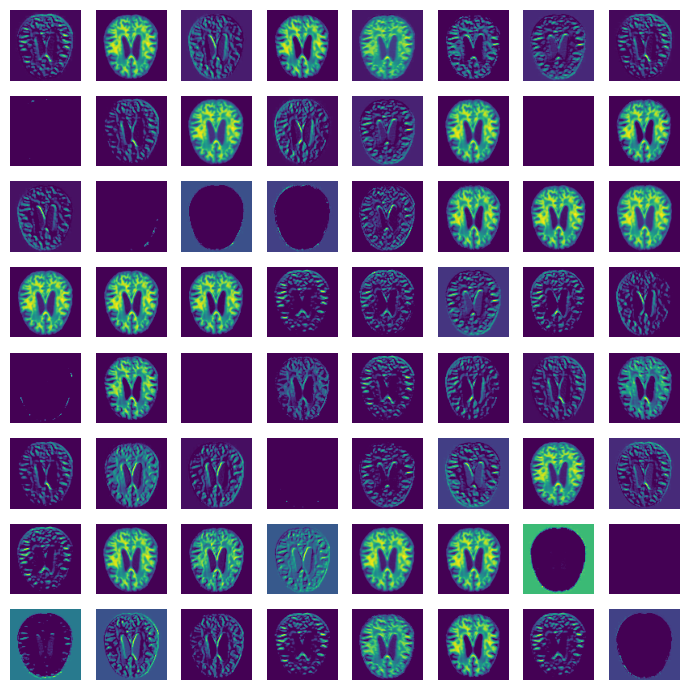

In [132]:
# Display all 64 filters after pooling conv1
n_cols = 8
n_rows = 8

fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 7))
conv1_filters = torch.tensor(features['pool_conv1'][0]).to(device='cpu')
print(conv1_filters.shape)

i = 0
j = 0
for i in range(n_rows):
    for j in range(n_cols) :
      #np_layer = conv1_filters[i+j*n_cols].transpose(0, 2).sum(-1).detach().numpy()
      np_layer = conv1_filters[i+j*n_cols].detach().numpy()
      axs[i,j].imshow(np_layer)
      #axs[i,j].set_title(f)
      axs[i,j].axis('off')

#plt.title('64 filters - output of MaxPool conv1 layer')
plt.tight_layout()
plt.show()

# Feature extraction - conv2
Display (120 out of) all 128 filters after conv2, before Maxpool

conv2 torch.Size([7, 128, 88, 88])

<ipython-input-133-663dd2fcaffa>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv1_filters = torch.tensor(features['conv2'][0]).to(device='cpu')


torch.Size([128, 88, 88])


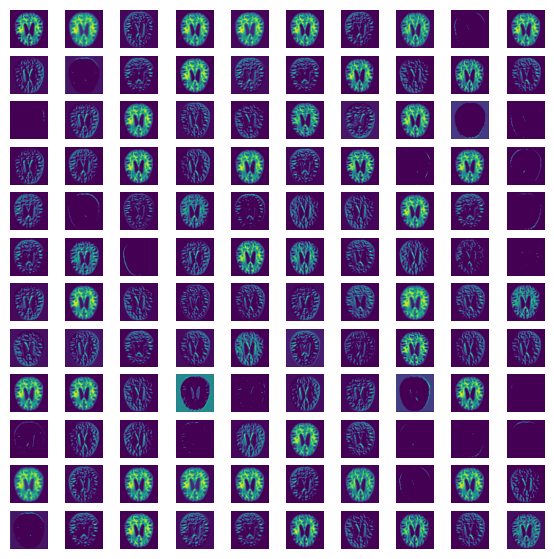

In [133]:


n_cols = 10
n_rows = 12

fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 7))
conv1_filters = torch.tensor(features['conv2'][0]).to(device='cpu')
print(conv1_filters.shape)

i = 0
j = 0
for i in range(n_rows):
    for j in range(n_cols) :
      #np_layer = conv1_filters[i+j*n_cols].transpose(0, 2).sum(-1).detach().numpy()
      np_layer = conv1_filters[i+j*n_cols].detach().numpy()
      axs[i,j].imshow(np_layer)
      #axs[i,j].set_title(f)
      axs[i,j].axis('off')

#plt.title('64 filters - output of MaxPool conv1 layer')
#plt.tight_layout()
plt.show()


<ipython-input-134-8dd8cd23df32>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv1_filters = torch.tensor(features['pool_conv2'][0]).to(device='cpu')


torch.Size([128, 44, 44])


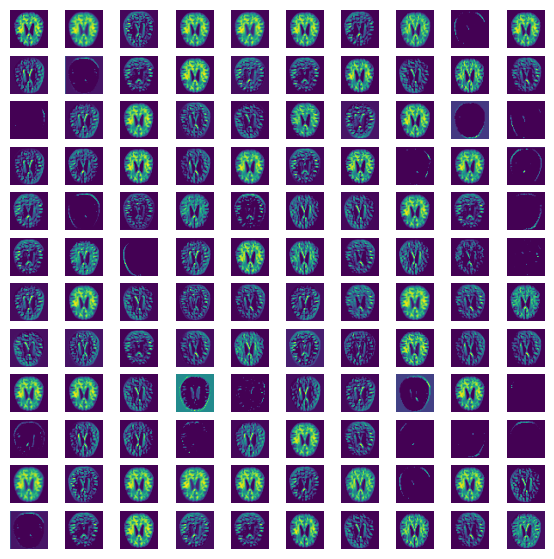

In [134]:
# Display (120 out of) all 128 filters after pooling conv2
# pool_conv2 torch.Size([7, 128, 44, 44])

n_cols = 10
n_rows = 12

fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 7))
conv1_filters = torch.tensor(features['pool_conv2'][0]).to(device='cpu')
print(conv1_filters.shape)

i = 0
j = 0
for i in range(n_rows):
    for j in range(n_cols) :
      #np_layer = conv1_filters[i+j*n_cols].transpose(0, 2).sum(-1).detach().numpy()
      np_layer = conv1_filters[i+j*n_cols].detach().numpy()
      axs[i,j].imshow(np_layer)
      #axs[i,j].set_title(f)
      axs[i,j].axis('off')

#plt.title('64 filters - output of MaxPool conv1 layer')
#plt.tight_layout()
plt.show()
